# Import des bibliothèques

In [56]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import prince as pr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, KFold

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

# Import des données

In [3]:
fourrage = pd.read_excel("INRA2018_TablesFourrages_etude_prediction_20241121.xlsx", engine="openpyxl", header = 1)

In [4]:
fourrage.head(3)

,No,Etat,Code INRA,Libellé 0,Libellé 1,Libellé 2,Libellé 3,Libellé 4,MS,UFL,...,GlyDI,AlaDI,TyrDI,C14:0,C16:0,C16:1,C18:0,C18:1,C18:2,C18:3
0,1,1,FV0010,FOURRAGES VERTS,"PRAIRIES PERMANENTES, PLAINE (NORMANDIE)",1er cycle,"15-25 avril, déprimage, ST = 172°C",NaN,15.5,1.07,...,6.94,6.87,4.13,1.0,15.68,1.4,2.30,4.04,16.34,54.50
1,2,1,FV0020,FOURRAGES VERTS,"PRAIRIES PERMANENTES, PLAINE (NORMANDIE)",1er cycle,"1-10 mai, pâturage, ST = 298°C",NaN,16.6,1.02,...,6.93,6.88,4.14,1.0,16.36,1.4,2.38,4.19,16.89,52.75
2,3,1,FV0030,FOURRAGES VERTS,"PRAIRIES PERMANENTES, PLAINE (NORMANDIE)",1er cycle,"15-25 mai, début épiaison, ST = 470°C",NaN,17.2,0.94,...,6.80,6.87,4.10,1.0,17.46,1.4,2.49,4.41,17.65,49.96


# Définition des variables

In [5]:
target = fourrage[["UFL", "UFV", "PDI", "BPR"]]
num_features = fourrage[["MM", "MAT", "CB", "NDF", "ADF", "EE"]]

# Arrangement des colonnes

## Arangement de libellé 1 en 3 sous colonnes (création de deux sous colonnes)

In [6]:
fourrage[["Libellé 1", "Libellé 1-2"]] = fourrage["Libellé 1"].str.split(",", n=1, expand=True)

In [7]:
cols = fourrage.columns.tolist()
print(cols)
cols.insert(cols.index('Libellé 1') + 1, cols.pop(cols.index('Libellé 1-2')))
fourrage = fourrage[cols]

['No', 'Etat', 'Code INRA', 'Libellé 0', 'Libellé 1', 'Libellé 2', 'Libellé 3', 'Libellé 4', 'MS', 'UFL', 'UFV', 'PDIA', 'PDI', 'BPR', 'LysDI', 'MetDI', 'HisDI', 'NIref', 'UEM', 'UEL', 'UEB', 'MO', 'MM', 'dMO', 'MAT', 'dMA', 'CB', 'dCB', 'NDF', 'dNDF', 'ADF', 'dADF', 'AG', 'EE', 'P', 'Pabs', 'Ca', 'Caabs', 'Mg', 'BE', 'EB', 'dE', 'EM', 'DT_N', 'DT6_N', 'dr_N', 'S', 'Na', 'K', 'Cl', 'BACA', 'Cu', 'Zn', 'Mn', 'Co', 'Se', 'I', 'VitA', 'VitD', 'VitE', 'LysBP', 'HisBP', 'ArgBP', 'ThrBP', 'ValBP', 'MetBP', 'IleBP', 'LeuBP', 'PheBP', 'AspBP', 'SerBP', 'GluBP', 'ProBP', 'GlyBP', 'AlaBP', 'TyrBP', 'CysTrpBP', 'LysDI.1', 'HisDI.1', 'ArgDI', 'ThrDI', 'ValDI', 'MetDI.1', 'IleDI', 'LeuDI', 'PheDI', 'AspDI', 'SerDI', 'GluDI', 'ProDI', 'GlyDI', 'AlaDI', 'TyrDI', 'C14:0', 'C16:0', 'C16:1', 'C18:0', 'C18:1', 'C18:2', 'C18:3', 'Libellé 1-2']


In [8]:
fourrage.head(1)

,No,Etat,Code INRA,Libellé 0,Libellé 1,Libellé 1-2,Libellé 2,Libellé 3,Libellé 4,MS,...,GlyDI,AlaDI,TyrDI,C14:0,C16:0,C16:1,C18:0,C18:1,C18:2,C18:3
0,1,1,FV0010,FOURRAGES VERTS,PRAIRIES PERMANENTES,PLAINE (NORMANDIE),1er cycle,"15-25 avril, déprimage, ST = 172°C",NaN,15.5,...,6.94,6.87,4.13,1.0,15.68,1.4,2.3,4.04,16.34,54.5


In [9]:
fourrage[["Libellé 1-2", "Libellé 1-3"]] = fourrage["Libellé 1-2"].str.split(",", n=1, expand=True)

In [10]:
cols = fourrage.columns.tolist()
print(cols)
cols.insert(cols.index('Libellé 1-2') + 1, cols.pop(cols.index('Libellé 1-3')))
fourrage = fourrage[cols]

['No', 'Etat', 'Code INRA', 'Libellé 0', 'Libellé 1', 'Libellé 1-2', 'Libellé 2', 'Libellé 3', 'Libellé 4', 'MS', 'UFL', 'UFV', 'PDIA', 'PDI', 'BPR', 'LysDI', 'MetDI', 'HisDI', 'NIref', 'UEM', 'UEL', 'UEB', 'MO', 'MM', 'dMO', 'MAT', 'dMA', 'CB', 'dCB', 'NDF', 'dNDF', 'ADF', 'dADF', 'AG', 'EE', 'P', 'Pabs', 'Ca', 'Caabs', 'Mg', 'BE', 'EB', 'dE', 'EM', 'DT_N', 'DT6_N', 'dr_N', 'S', 'Na', 'K', 'Cl', 'BACA', 'Cu', 'Zn', 'Mn', 'Co', 'Se', 'I', 'VitA', 'VitD', 'VitE', 'LysBP', 'HisBP', 'ArgBP', 'ThrBP', 'ValBP', 'MetBP', 'IleBP', 'LeuBP', 'PheBP', 'AspBP', 'SerBP', 'GluBP', 'ProBP', 'GlyBP', 'AlaBP', 'TyrBP', 'CysTrpBP', 'LysDI.1', 'HisDI.1', 'ArgDI', 'ThrDI', 'ValDI', 'MetDI.1', 'IleDI', 'LeuDI', 'PheDI', 'AspDI', 'SerDI', 'GluDI', 'ProDI', 'GlyDI', 'AlaDI', 'TyrDI', 'C14:0', 'C16:0', 'C16:1', 'C18:0', 'C18:1', 'C18:2', 'C18:3', 'Libellé 1-3']


## Arrangement de libellé 2 : split en 3 colonnes

In [11]:
fourrage[["Libellé 2", "Libellé 2-1"]] = fourrage["Libellé 2"].str.split(",", n=1, expand=True)

In [12]:
cols = fourrage.columns.tolist()
print(cols)
cols.insert(cols.index('Libellé 2') + 1, cols.pop(cols.index('Libellé 2-1')))
fourrage = fourrage[cols]

['No', 'Etat', 'Code INRA', 'Libellé 0', 'Libellé 1', 'Libellé 1-2', 'Libellé 1-3', 'Libellé 2', 'Libellé 3', 'Libellé 4', 'MS', 'UFL', 'UFV', 'PDIA', 'PDI', 'BPR', 'LysDI', 'MetDI', 'HisDI', 'NIref', 'UEM', 'UEL', 'UEB', 'MO', 'MM', 'dMO', 'MAT', 'dMA', 'CB', 'dCB', 'NDF', 'dNDF', 'ADF', 'dADF', 'AG', 'EE', 'P', 'Pabs', 'Ca', 'Caabs', 'Mg', 'BE', 'EB', 'dE', 'EM', 'DT_N', 'DT6_N', 'dr_N', 'S', 'Na', 'K', 'Cl', 'BACA', 'Cu', 'Zn', 'Mn', 'Co', 'Se', 'I', 'VitA', 'VitD', 'VitE', 'LysBP', 'HisBP', 'ArgBP', 'ThrBP', 'ValBP', 'MetBP', 'IleBP', 'LeuBP', 'PheBP', 'AspBP', 'SerBP', 'GluBP', 'ProBP', 'GlyBP', 'AlaBP', 'TyrBP', 'CysTrpBP', 'LysDI.1', 'HisDI.1', 'ArgDI', 'ThrDI', 'ValDI', 'MetDI.1', 'IleDI', 'LeuDI', 'PheDI', 'AspDI', 'SerDI', 'GluDI', 'ProDI', 'GlyDI', 'AlaDI', 'TyrDI', 'C14:0', 'C16:0', 'C16:1', 'C18:0', 'C18:1', 'C18:2', 'C18:3', 'Libellé 2-1']


In [13]:
fourrage['Libellé 2-1'].str.contains(',', na=False).any()

True

In [14]:
fourrage[["Libellé 2-1", "Libellé 2-2"]] = fourrage["Libellé 2-1"].str.split(",", n=1, expand=True)

In [15]:
cols = fourrage.columns.tolist()
print(cols)
cols.insert(cols.index('Libellé 2-1') + 1, cols.pop(cols.index('Libellé 2-2')))
fourrage = fourrage[cols]

['No', 'Etat', 'Code INRA', 'Libellé 0', 'Libellé 1', 'Libellé 1-2', 'Libellé 1-3', 'Libellé 2', 'Libellé 2-1', 'Libellé 3', 'Libellé 4', 'MS', 'UFL', 'UFV', 'PDIA', 'PDI', 'BPR', 'LysDI', 'MetDI', 'HisDI', 'NIref', 'UEM', 'UEL', 'UEB', 'MO', 'MM', 'dMO', 'MAT', 'dMA', 'CB', 'dCB', 'NDF', 'dNDF', 'ADF', 'dADF', 'AG', 'EE', 'P', 'Pabs', 'Ca', 'Caabs', 'Mg', 'BE', 'EB', 'dE', 'EM', 'DT_N', 'DT6_N', 'dr_N', 'S', 'Na', 'K', 'Cl', 'BACA', 'Cu', 'Zn', 'Mn', 'Co', 'Se', 'I', 'VitA', 'VitD', 'VitE', 'LysBP', 'HisBP', 'ArgBP', 'ThrBP', 'ValBP', 'MetBP', 'IleBP', 'LeuBP', 'PheBP', 'AspBP', 'SerBP', 'GluBP', 'ProBP', 'GlyBP', 'AlaBP', 'TyrBP', 'CysTrpBP', 'LysDI.1', 'HisDI.1', 'ArgDI', 'ThrDI', 'ValDI', 'MetDI.1', 'IleDI', 'LeuDI', 'PheDI', 'AspDI', 'SerDI', 'GluDI', 'ProDI', 'GlyDI', 'AlaDI', 'TyrDI', 'C14:0', 'C16:0', 'C16:1', 'C18:0', 'C18:1', 'C18:2', 'C18:3', 'Libellé 2-2']


In [16]:
fourrage['Libellé 2-1'].str.contains(',', na=False).any()

False

## Arrangement de libellé 3 : division en 3 colonnes

In [17]:
fourrage['Libellé 3'].str.contains(',', na=False).any()

True

In [18]:
fourrage[["Libellé 3", "Libellé 3-1"]] = fourrage["Libellé 3"].str.split(",", n=1, expand=True)

In [19]:
cols = fourrage.columns.tolist()
print(cols)
cols.insert(cols.index('Libellé 3') + 1, cols.pop(cols.index('Libellé 3-1')))
fourrage = fourrage[cols]

['No', 'Etat', 'Code INRA', 'Libellé 0', 'Libellé 1', 'Libellé 1-2', 'Libellé 1-3', 'Libellé 2', 'Libellé 2-1', 'Libellé 2-2', 'Libellé 3', 'Libellé 4', 'MS', 'UFL', 'UFV', 'PDIA', 'PDI', 'BPR', 'LysDI', 'MetDI', 'HisDI', 'NIref', 'UEM', 'UEL', 'UEB', 'MO', 'MM', 'dMO', 'MAT', 'dMA', 'CB', 'dCB', 'NDF', 'dNDF', 'ADF', 'dADF', 'AG', 'EE', 'P', 'Pabs', 'Ca', 'Caabs', 'Mg', 'BE', 'EB', 'dE', 'EM', 'DT_N', 'DT6_N', 'dr_N', 'S', 'Na', 'K', 'Cl', 'BACA', 'Cu', 'Zn', 'Mn', 'Co', 'Se', 'I', 'VitA', 'VitD', 'VitE', 'LysBP', 'HisBP', 'ArgBP', 'ThrBP', 'ValBP', 'MetBP', 'IleBP', 'LeuBP', 'PheBP', 'AspBP', 'SerBP', 'GluBP', 'ProBP', 'GlyBP', 'AlaBP', 'TyrBP', 'CysTrpBP', 'LysDI.1', 'HisDI.1', 'ArgDI', 'ThrDI', 'ValDI', 'MetDI.1', 'IleDI', 'LeuDI', 'PheDI', 'AspDI', 'SerDI', 'GluDI', 'ProDI', 'GlyDI', 'AlaDI', 'TyrDI', 'C14:0', 'C16:0', 'C16:1', 'C18:0', 'C18:1', 'C18:2', 'C18:3', 'Libellé 3-1']


In [20]:
fourrage['Libellé 3-1'].str.contains(',', na=False).any()

True

In [21]:
fourrage[["Libellé 3-1", "Libellé 3-2"]] = fourrage["Libellé 3-1"].str.split(",", n=1, expand=True)

In [22]:
cols = fourrage.columns.tolist()
print(cols)
cols.insert(cols.index('Libellé 3-1') + 1, cols.pop(cols.index('Libellé 3-2')))
fourrage = fourrage[cols]

['No', 'Etat', 'Code INRA', 'Libellé 0', 'Libellé 1', 'Libellé 1-2', 'Libellé 1-3', 'Libellé 2', 'Libellé 2-1', 'Libellé 2-2', 'Libellé 3', 'Libellé 3-1', 'Libellé 4', 'MS', 'UFL', 'UFV', 'PDIA', 'PDI', 'BPR', 'LysDI', 'MetDI', 'HisDI', 'NIref', 'UEM', 'UEL', 'UEB', 'MO', 'MM', 'dMO', 'MAT', 'dMA', 'CB', 'dCB', 'NDF', 'dNDF', 'ADF', 'dADF', 'AG', 'EE', 'P', 'Pabs', 'Ca', 'Caabs', 'Mg', 'BE', 'EB', 'dE', 'EM', 'DT_N', 'DT6_N', 'dr_N', 'S', 'Na', 'K', 'Cl', 'BACA', 'Cu', 'Zn', 'Mn', 'Co', 'Se', 'I', 'VitA', 'VitD', 'VitE', 'LysBP', 'HisBP', 'ArgBP', 'ThrBP', 'ValBP', 'MetBP', 'IleBP', 'LeuBP', 'PheBP', 'AspBP', 'SerBP', 'GluBP', 'ProBP', 'GlyBP', 'AlaBP', 'TyrBP', 'CysTrpBP', 'LysDI.1', 'HisDI.1', 'ArgDI', 'ThrDI', 'ValDI', 'MetDI.1', 'IleDI', 'LeuDI', 'PheDI', 'AspDI', 'SerDI', 'GluDI', 'ProDI', 'GlyDI', 'AlaDI', 'TyrDI', 'C14:0', 'C16:0', 'C16:1', 'C18:0', 'C18:1', 'C18:2', 'C18:3', 'Libellé 3-2']


In [23]:
fourrage['Libellé 3-1'].str.contains(',', na=False).any()

False

## Arrangement de libellé 4

In [24]:
fourrage['Libellé 4'].str.contains(',', na=False).any()

True

In [25]:
fourrage[["Libellé 4", "Libellé 4-1"]] = fourrage["Libellé 4"].str.split(",", n=1, expand=True)

In [26]:
cols = fourrage.columns.tolist()
print(cols)
cols.insert(cols.index('Libellé 4') + 1, cols.pop(cols.index('Libellé 4-1')))
fourrage = fourrage[cols]

['No', 'Etat', 'Code INRA', 'Libellé 0', 'Libellé 1', 'Libellé 1-2', 'Libellé 1-3', 'Libellé 2', 'Libellé 2-1', 'Libellé 2-2', 'Libellé 3', 'Libellé 3-1', 'Libellé 3-2', 'Libellé 4', 'MS', 'UFL', 'UFV', 'PDIA', 'PDI', 'BPR', 'LysDI', 'MetDI', 'HisDI', 'NIref', 'UEM', 'UEL', 'UEB', 'MO', 'MM', 'dMO', 'MAT', 'dMA', 'CB', 'dCB', 'NDF', 'dNDF', 'ADF', 'dADF', 'AG', 'EE', 'P', 'Pabs', 'Ca', 'Caabs', 'Mg', 'BE', 'EB', 'dE', 'EM', 'DT_N', 'DT6_N', 'dr_N', 'S', 'Na', 'K', 'Cl', 'BACA', 'Cu', 'Zn', 'Mn', 'Co', 'Se', 'I', 'VitA', 'VitD', 'VitE', 'LysBP', 'HisBP', 'ArgBP', 'ThrBP', 'ValBP', 'MetBP', 'IleBP', 'LeuBP', 'PheBP', 'AspBP', 'SerBP', 'GluBP', 'ProBP', 'GlyBP', 'AlaBP', 'TyrBP', 'CysTrpBP', 'LysDI.1', 'HisDI.1', 'ArgDI', 'ThrDI', 'ValDI', 'MetDI.1', 'IleDI', 'LeuDI', 'PheDI', 'AspDI', 'SerDI', 'GluDI', 'ProDI', 'GlyDI', 'AlaDI', 'TyrDI', 'C14:0', 'C16:0', 'C16:1', 'C18:0', 'C18:1', 'C18:2', 'C18:3', 'Libellé 4-1']


In [28]:
fourrage['Libellé 4-1'].str.contains(',', na=False).any()

True

In [29]:
fourrage[["Libellé 4-1", "Libellé 4-2"]] = fourrage["Libellé 4-1"].str.split(",", n=1, expand=True)

In [30]:
cols = fourrage.columns.tolist()
print(cols)
cols.insert(cols.index('Libellé 4-1') + 1, cols.pop(cols.index('Libellé 4-2')))
fourrage = fourrage[cols]

['No', 'Etat', 'Code INRA', 'Libellé 0', 'Libellé 1', 'Libellé 1-2', 'Libellé 1-3', 'Libellé 2', 'Libellé 2-1', 'Libellé 2-2', 'Libellé 3', 'Libellé 3-1', 'Libellé 3-2', 'Libellé 4', 'Libellé 4-1', 'MS', 'UFL', 'UFV', 'PDIA', 'PDI', 'BPR', 'LysDI', 'MetDI', 'HisDI', 'NIref', 'UEM', 'UEL', 'UEB', 'MO', 'MM', 'dMO', 'MAT', 'dMA', 'CB', 'dCB', 'NDF', 'dNDF', 'ADF', 'dADF', 'AG', 'EE', 'P', 'Pabs', 'Ca', 'Caabs', 'Mg', 'BE', 'EB', 'dE', 'EM', 'DT_N', 'DT6_N', 'dr_N', 'S', 'Na', 'K', 'Cl', 'BACA', 'Cu', 'Zn', 'Mn', 'Co', 'Se', 'I', 'VitA', 'VitD', 'VitE', 'LysBP', 'HisBP', 'ArgBP', 'ThrBP', 'ValBP', 'MetBP', 'IleBP', 'LeuBP', 'PheBP', 'AspBP', 'SerBP', 'GluBP', 'ProBP', 'GlyBP', 'AlaBP', 'TyrBP', 'CysTrpBP', 'LysDI.1', 'HisDI.1', 'ArgDI', 'ThrDI', 'ValDI', 'MetDI.1', 'IleDI', 'LeuDI', 'PheDI', 'AspDI', 'SerDI', 'GluDI', 'ProDI', 'GlyDI', 'AlaDI', 'TyrDI', 'C14:0', 'C16:0', 'C16:1', 'C18:0', 'C18:1', 'C18:2', 'C18:3', 'Libellé 4-2']


In [31]:
fourrage['Libellé 4-1'].str.contains(',', na=False).any()

False

In [32]:
del cols

Ok plus de virgules !

# Définition de la variable objet obj_features

In [33]:
obj_features = fourrage.drop(["Code INRA"], axis=1).select_dtypes(include="object")

In [34]:
obj_features.head(3)

,Libellé 0,Libellé 1,Libellé 1-2,Libellé 1-3,Libellé 2,Libellé 2-1,Libellé 2-2,Libellé 3,Libellé 3-1,Libellé 3-2,Libellé 4,Libellé 4-1,Libellé 4-2
0,FOURRAGES VERTS,PRAIRIES PERMANENTES,PLAINE (NORMANDIE),None,1er cycle,None,None,15-25 avril,déprimage,ST = 172°C,NaN,NaN,NaN
1,FOURRAGES VERTS,PRAIRIES PERMANENTES,PLAINE (NORMANDIE),None,1er cycle,None,None,1-10 mai,pâturage,ST = 298°C,NaN,NaN,NaN
2,FOURRAGES VERTS,PRAIRIES PERMANENTES,PLAINE (NORMANDIE),None,1er cycle,None,None,15-25 mai,début épiaison,ST = 470°C,NaN,NaN,NaN


In [35]:
for col in obj_features.columns :
    print("=" * 60)
    print(obj_features[col].value_counts())


Libellé 0
ENSILAGES                       307
FOURRAGES VERTS                 294
FOINS                           279
PAILLES, FOURRAGES LIGNIFIÉS     21
RACINES ET TUBERCULES            12
Name: count, dtype: int64
Libellé 1
GRAMINÉES FOURRAGÈRES                502
PRAIRIES PERMANENTES                 147
LÉGUMINEUSES FOURRAGÈRES             147
CÉRÉALES PLANTES ENTIÈRES             44
PROTÉAGINEUX                          17
CRUCIFÈRES                            12
COMPOSÉES                             11
Paille de Blé                          4
Paille d'Orge                          4
Cannes de Maïs                         3
Betteraves Fourragères                 2
Spathes de Maïs                        2
Paille de Sorgho                       2
Paille de Riz                          2
Feuilles et collets de betteraves      2
Topinambour                            1
Rutabagas                              1
Endives                                1
Pommes de terre                     

# Définition des fontions d'intérêts

In [36]:
# Pas de variables catégorielles, seulement numériques, sur lesquelles on prend une standardisation

def OptimisationNumOny(target_features) :
    
    scaler = StandardScaler()
    num_features_T = pd.DataFrame(scaler.fit_transform(num_features), columns = num_features.columns)
    target_features_T = pd.DataFrame(scaler.fit_transform(target_features), columns = target_features.columns)
    
    for col in num_features_T.columns:
        na_count = num_features_T[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention NA ({na_count} valeurs manquantes)")
        
    num_features_T = num_features_T.dropna()
    
    for col in num_features_T.columns:
        na_count = num_features_T[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention encore NA ({na_count} valeurs manquantes)")
        else :
            print("Ok pas de valeurs manquantes")
    
    df_t = pd.concat([num_features_T, target_features_T], axis=1)
    
    for col in df_t.columns:
        na_count = df_t[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention NA ({na_count} valeurs manquantes)")
    
    df_t = df_t.dropna()
    
    for col in df_t.columns:
        na_count = df_t[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention encore NA ({na_count} valeurs manquantes)")
        else :
            print("Ok plus de valeurs manquantes !")

    X_temp = df_t.drop(target, axis = 1)
    Y_temp = df_t[target.columns]
    
    X_temp.columns = [str(i) for i in range(X_temp.shape[1])]
    
    return X_temp, Y_temp

In [37]:
test1, test2 = Optimisation_avec_MCA_avec_PCA_avant(3, target)
df = PerfDesModeles(test1, test2, metrique_num=True, graph_affich=False)
best_model(df)

NameError: name 'Optimisation_avec_MCA_avec_PCA_avant' is not defined

In [38]:
# OneHot seulement sur les données catégorielles, pas de numériques :

def OptimisationOneHot(nb_colonne_obj, target_features) :
    
    obj_features_temp = obj_features.iloc[:, 0:nb_colonne_obj]
    
    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    obj_features_temp_enc = enc.fit_transform(obj_features_temp)
    
    obj_features_temp_enc = pd.DataFrame(
        obj_features_temp_enc,
        columns = enc.get_feature_names_out(obj_features_temp.columns),
        index = obj_features_temp.index)
    
    scaler = StandardScaler()
    target_features_T = pd.DataFrame(scaler.fit_transform(target_features), columns = target_features.columns)
    
    df_t = pd.concat([obj_features_temp_enc, target_features_T], axis=1)
    
    for col in df_t.columns:
        na_count = df_t[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention NA ({na_count} valeurs manquantes)")
    
    df_t = df_t.dropna()
    
    X_temp = df_t.drop(target, axis = 1)
    Y_temp = df_t[target.columns]
    
    # print("len :", X_temp.shape[1])
    X_temp.columns = [str(i) for i in range(X_temp.shape[1])]
    
    return X_temp, Y_temp

In [39]:
# One Hot + concaténation avec les numériques + séparation de X et Y + return X et Y

def Optimisation_sans_MCA_sans_PCA(nb_colonne_obj, target_features) :
    
    obj_features_temp = obj_features.iloc[:, 0:nb_colonne_obj]
    
    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    obj_features_temp_enc = enc.fit_transform(obj_features_temp)
    
    obj_features_temp_enc = pd.DataFrame(
        obj_features_temp_enc,
        columns = enc.get_feature_names_out(obj_features_temp.columns),
        index = obj_features_temp.index)
    
    scaler = StandardScaler()
    num_features_T = pd.DataFrame(scaler.fit_transform(num_features), columns = num_features.columns)
    target_features_T = pd.DataFrame(scaler.fit_transform(target_features), columns = target_features.columns)
    
    df_t = pd.concat([obj_features_temp_enc, num_features_T, target_features_T], axis=1)
    
    for col in df_t.columns:
        na_count = df_t[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention NA ({na_count} valeurs manquantes)")
    
    df_t = df_t.dropna()
    
    X_temp = df_t.drop(target, axis = 1)
    Y_temp = df_t[target.columns]
    
    # print("len :", X_temp.shape[1])
    X_temp.columns = [str(i) for i in range(X_temp.shape[1]-7)] + ["MM", "MAT", "CB", "NDF", "ADF", "EE", "PDIE"]
    
    return X_temp, Y_temp

In [40]:
# One Hot + mca sur le OneHot + concaténation avec standardisation + séparation de X et Y + return X et Y

def Optimisation_avec_MCA_sans_PCA(nb_colonne_obj, target_features) :
    
    mca_temp = pr.MCA(
        n_components=nb_colonne_obj,
        n_iter=5,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=0)
    
    obj_features_temp = obj_features.iloc[:, 0:nb_colonne_obj]
    
    mca_temp.fit(obj_features)
    obj_features_N = mca_temp.transform(obj_features)
    
    scaler = StandardScaler()
    num_features_T = pd.DataFrame(scaler.fit_transform(num_features), columns = num_features.columns)
    target_features_T = pd.DataFrame(scaler.fit_transform(target_features), columns = target_features.columns)
    
    df_t = pd.concat([obj_features_N, num_features_T, target_features_T], axis=1)
    
    for col in df_t.columns:
        na_count = df_t[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention NA ({na_count} valeurs manquantes)")
    
    df_t = df_t.dropna()
    
    for col in df_t.columns:
        na_count = df_t[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention encore NA ({na_count} valeurs manquantes)")

    X_temp = df_t.drop(target, axis = 1)
    Y_temp = df_t[target.columns]
    
    X_temp.columns = [str(i) for i in range(X_temp.shape[1]-7)] + ["MM", "MAT", "CB", "NDF", "ADF", "EE", "PDIE"]
    
    return X_temp, Y_temp

In [41]:
# One Hot + mca sur le OneHot + standardisation des données catégorielles + PCA + concaténation + séparation de X et Y + return X et Y

def Optimisation_avec_MCA_avec_PCA_avant(nb_colonne_obj, target_features) :
    
    mca_temp = pr.MCA(
        n_components=nb_colonne_obj,
        n_iter=5,
        copy=True,
        check_input=True,
        engine='sklearn',
        random_state=0)
    
    obj_features_temp = obj_features.iloc[:, 0:nb_colonne_obj]
    
    mca_temp.fit(obj_features)
    obj_features_N = mca_temp.transform(obj_features)
    
    scaler = StandardScaler()
    num_features_T = pd.DataFrame(scaler.fit_transform(num_features), columns = num_features.columns)
    target_features_T = pd.DataFrame(scaler.fit_transform(target_features), columns = target_features.columns)
    
    for col in num_features_T.columns:
        na_count = num_features_T[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention NA ({na_count} valeurs manquantes)")
        
    num_features_T = num_features_T.dropna()
    
    for col in num_features_T.columns:
        na_count = num_features_T[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention encore NA ({na_count} valeurs manquantes)")
        else :
            print("Ok pas de valeurs manquantes")
    
    pca = PCA(n_components = num_features_T.shape[1])
    num_features_TN = pca.fit_transform(num_features_T)
    
    num_features_TN = pd.DataFrame(num_features_TN, columns=[f"PCA_{i}" for i in range(num_features_TN.shape[1])])
    
    df_t = pd.concat([obj_features_N, num_features_TN, target_features_T], axis=1)
    
    # for col in df_t.columns:
    #     na_count = df_t[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
    #     if na_count > 0:  # Si au moins une valeur manquante
    #         print(f"Colonne {col} : attention NA ({na_count} valeurs manquantes)")
    
    df_t = df_t.dropna()
    
    # for col in df_t.columns:
    #     na_count = df_t[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
    #     if na_count > 0:  # Si au moins une valeur manquante
    #         print(f"Colonne {col} : attention encore NA ({na_count} valeurs manquantes)")

    X_temp = df_t.drop(target, axis = 1)
    Y_temp = df_t[target.columns]
    
    X_temp.columns = [str(i) for i in range(X_temp.shape[1])]
    
    return X_temp, Y_temp

In [42]:
# Concaténation des variables catégorielles et numériques + FAMD + séparation de X et Y + return X et Y

def Optimisation_avec_FAMD(nb_colonne_obj, target_features) :
    
    obj_features_temp = obj_features.iloc[:, 0:nb_colonne_obj]
    
    df_temporaire = pd.concat([obj_features_temp, num_features], axis=1)
    
    scaler = StandardScaler()
    #num_features_T = pd.DataFrame(scaler.fit_transform(num_features), columns = num_features.columns)
    
    for col in df_temporaire.columns:
        na_count = df_temporaire[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention NA ({na_count} valeurs manquantes)")
        
    df_temporaire = df_temporaire.dropna()
    
    for col in df_temporaire.columns:
        na_count = df_temporaire[col].isna().sum()  # Nombre de valeurs manquantes dans la colonne
        if na_count > 0:  # Si au moins une valeur manquante
            print(f"Colonne {col} : attention encore NA ({na_count} valeurs manquantes)")
        else :
            print("Ok pas de valeurs manquantes")
        
    famd = pr.FAMD(
    n_components=df_temporaire.shape[1],
    n_iter=5,
    copy=True,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="ignore" # same parameter as sklearn.preprocessing.OneHotEncoder
)
    
    famd = famd.fit(df_temporaire)
    df_t = famd.transform(df_temporaire)
    
    target_features_T = pd.DataFrame(scaler.fit_transform(target_features), columns = target_features.columns)
    
    df_t = pd.concat([df_t, target_features_T], axis=1)

    X_temp = df_t.drop(target, axis = 1)
    Y_temp = df_t[target.columns]
    
    X_temp.columns = [str(i) for i in range(X_temp.shape[1])]
    
    return X_temp, Y_temp

In [80]:
# Prend X et Y + séparation train et test + evaluation par chaque modèle + renvoie de plusieurs métriques pour les différents paramètres

def PerfDesModeles(X_t, Y_t, metrique_num = True, graph_affich = True):
    # Définition des cibles
    target = ["UFV", "UFL", "PDI", "BPR"]

    # Liste des modèles à évaluer
    models = [
        LinearRegression(), Ridge(), SVR(), DecisionTreeRegressor(),
        RandomForestRegressor(), GradientBoostingRegressor(),
        XGBRegressor(), MLPRegressor(), KNeighborsRegressor()
    ]

    # Listes pour stocker les métriques globales
    mape_tot, max_error_tot, mae_tot, r2_tot = [], [], [], []

    # Parcours de chaque variable cible
    for tar in target:
        # Extraction de la cible
        Y_t_temp = Y_t[tar]

        # Division des données en ensembles d'entraînement et de test
        X_train, X_test, Y_train, Y_test = train_test_split(
            X_t, Y_t_temp, test_size=0.33, random_state=0, shuffle=True
        )

        # Conversion des noms de colonnes en chaînes de caractères (si nécessaire)
        X_train.columns = X_train.columns.astype('str')
        X_test.columns = X_test.columns.astype('str')

        # Listes temporaires pour stocker les métriques d'une seule cible
        mape_temp, max_error_temp, mae_temp, r2_temp = [], [], [], []

        # Évaluation de chaque modèle
        for model in models:
            # Entraînement et prédiction
            model.fit(X_train, Y_train)
            Yhat = model.predict(X_test)

            # Calcul des métriques
            mape_temp.append(mean_absolute_percentage_error(Y_test, Yhat).round(4))
            max_error_temp.append(max_error(Y_test, Yhat).round(4))
            mae_temp.append(mean_absolute_error(Y_test, Yhat).round(4))
            r2_temp.append(r2_score(Y_test, Yhat))

        # Ajout des résultats pour la cible en cours
        mape_tot.append(mape_temp)
        max_error_tot.append(max_error_temp)
        mae_tot.append(mae_temp)
        r2_tot.append(r2_temp)

    # Noms des modèles pour indexer les DataFrames
    model_names = [model.__class__.__name__ for model in models]

    # Création des DataFrames pour chaque métrique
    mape_df = pd.DataFrame(mape_tot, columns=model_names, index=target).T
    max_error_df = pd.DataFrame(max_error_tot, columns=model_names, index=target).T
    mae_df = pd.DataFrame(mae_tot, columns=model_names, index=target).T
    r2_df = pd.DataFrame(r2_tot, columns=model_names, index=target).T

    # Liste des métriques et leurs titres pour la visualisation
    metriques = [
        (mape_df, "MAPE (Mean Absolute Percentage Error)"),
        (max_error_df, "Erreur Maximale"),
        (mae_df, "MAE (Mean Absolute Error)"),
        (r2_df, "R² (Coefficient de Détermination)")
    ]

    # Visualisation des résultats sous forme de heatmaps
    if graph_affich == True :
        for df, title in metriques:
            plt.figure(figsize=(6, 4))
            sns.heatmap(df, annot=True, cmap="pink", fmt=".4g")
            plt.title(title)
            plt.show()
            
    # Return éventuelle des métriques :
    if metrique_num == True :
        return r2_df

In [87]:
def PerfDesModeles2(X_t, Y_t, cv=5, metrique_num=True, graph_affich=True):
    # Définition des cibles
    targets = ["UFV", "UFL", "PDI", "BPR"]

    # Liste des modèles à évaluer
    models = [
        LinearRegression(), Ridge(), SVR(), DecisionTreeRegressor(),
        RandomForestRegressor(), GradientBoostingRegressor(),
        XGBRegressor(), MLPRegressor(), KNeighborsRegressor()
    ]

    # Création d'un validateur K-Fold
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Listes pour stocker les métriques globales
    neg_mean_absolute_percentage_error_tot, max_error_tot, mae_tot, r2_tot = [], [], [], []

    # Parcours de chaque variable cible
    for target in targets:
        # Extraction de la cible
        Y_t_temp = Y_t[target]

        # Listes temporaires pour stocker les métriques pour cette cible
        neg_mean_absolute_percentage_error_temp, max_error_temp, mae_temp, r2_temp = [], [], [], []

        # Évaluation de chaque modèle
        for model in models:
            # Calcul des scores via cross-validation
            neg_mean_absolute_percentage_error_scores = cross_val_score(
                model, X_t, Y_t_temp, cv=kf,
                scoring="neg_mean_absolute_percentage_error"
            )
            max_error_scores = cross_val_score(
                model, X_t, Y_t_temp, cv=kf,
                scoring="max_error"
            )
            mae_scores = cross_val_score(
                model, X_t, Y_t_temp, cv=kf,
                scoring="neg_mean_absolute_error"
            )
            r2_scores = cross_val_score(
                model, X_t, Y_t_temp, cv=kf,
                scoring="r2"
            )

            # Moyenne des métriques (en inversant les métriques négatives)
            neg_mean_absolute_percentage_error_temp.append(-neg_mean_absolute_percentage_error_scores.mean().round(4))
            max_error_temp.append(-max_error_scores.mean().round(4))
            mae_temp.append(-mae_scores.mean().round(4))
            r2_temp.append(r2_scores.mean().round(4))

        # Ajout des résultats pour la cible actuelle
        neg_mean_absolute_percentage_error_tot.append(neg_mean_absolute_percentage_error_temp)
        max_error_tot.append(max_error_temp)
        mae_tot.append(mae_temp)
        r2_tot.append(r2_temp)

    # Noms des modèles pour indexer les DataFrames
    model_names = [model.__class__.__name__ for model in models]

    # Création des DataFrames pour chaque métrique
    neg_mean_absolute_percentage_error_df = pd.DataFrame(neg_mean_absolute_percentage_error_tot, columns=model_names, index=targets).T
    max_error_df = pd.DataFrame(max_error_tot, columns=model_names, index=targets).T
    mae_df = pd.DataFrame(mae_tot, columns=model_names, index=targets).T
    r2_df = pd.DataFrame(r2_tot, columns=model_names, index=targets).T

    # Liste des métriques et leurs titres pour la visualisation
    metriques = [
        (neg_mean_absolute_percentage_error_df, "Neg_mean_absolute_percentage_error"),
        (max_error_df, "Erreur Maximale"),
        (mae_df, "MAE (Mean Absolute Error)"),
        (r2_df, "R² (Coefficient de Détermination)")
    ]

    # Visualisation des résultats sous forme de heatmaps
    if graph_affich:
        for df, title in metriques:
            plt.figure(figsize=(8, 5))
            sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".4g")
            plt.title(title)
            plt.show()

    # Retour éventuel des métriques
    if metrique_num:
        return neg_mean_absolute_percentage_error_df

In [71]:
# Prends un tableau de résultats et renvoie le meilleur score et le meilleure modèle pour chaque colonne du tableau

def best_model(df):
    
    cible = []
    best_mod = []
    best_score = []
    
    for col in df.columns:
        # Trouver l'index de la valeur maximale pour chaque colonne
        index_max_score = np.argmax(df[col])

        # Enregistrer le score maximal
        best_score.append(df[col].iloc[index_max_score])

        # Enregistrer le nom du modèle correspondant (index du DataFrame)
        best_mod.append(df.index[index_max_score])
        
        # Enregistrement des cibles
        cible.append(col)

    df = pd.DataFrame(list(zip(cible, best_mod, best_score)), columns=['cible', 'Model', 'neg_mean_absolute_percentage_error score'])
    
    # Retourner les scores et modèles sous forme de liste
    return df

In [91]:
# Prends un tableau de résultats et renvoie le meilleur score et le meilleure modèle pour chaque colonne du tableau

def best_model2(df):
    
    cible = []
    best_mod = []
    best_score = []
    
    for col in df.columns:
        # Trouver l'index de la valeur maximale pour chaque colonne
        index_min_score = np.argmin(df[col])

        # Enregistrer le score maximal
        best_score.append(df[col].iloc[index_min_score])

        # Enregistrer le nom du modèle correspondant (index du DataFrame)
        best_mod.append(df.index[index_min_score])
        
        # Enregistrement des cibles
        cible.append(col)

    df = pd.DataFrame(list(zip(cible, best_mod, best_score)), columns=['cible', 'Model', 'neg_mean_absolute_percentage_error score'])
    
    # Retourner les scores et modèles sous forme de liste
    return df

## Test

In [86]:
X, y = Optimisation_sans_MCA_sans_PCA(2, target)
df = PerfDesModeles(X, y, graph_affich=False)
print(df)

Colonne ADF : attention NA (3 valeurs manquantes)
Colonne EE : attention NA (1 valeurs manquantes)


c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


                                    UFV           UFL           PDI  \
LinearRegression          -1.323175e+23 -1.462733e+23 -3.852716e+22   
Ridge                      7.719819e-01  7.642693e-01  9.154393e-01   
SVR                        7.621541e-01  7.729550e-01  9.290498e-01   
DecisionTreeRegressor      6.300024e-01  5.643341e-01  8.814116e-01   
RandomForestRegressor      8.008735e-01  8.045252e-01  9.196154e-01   
GradientBoostingRegressor  7.902764e-01  7.864537e-01  9.181252e-01   
XGBRegressor               7.683867e-01  7.649744e-01  9.082117e-01   
MLPRegressor               7.942465e-01  7.990715e-01  9.375258e-01   
KNeighborsRegressor        7.812803e-01  7.772166e-01  8.914687e-01   

                                    BPR  
LinearRegression          -4.019014e+21  
Ridge                      9.830976e-01  
SVR                        9.448993e-01  
DecisionTreeRegressor      9.654940e-01  
RandomForestRegressor      9.798013e-01  
GradientBoostingRegressor  9.832942e-

In [84]:
best_model(df)

,cible,Model,R2 Score
0,UFV,RandomForestRegressor,0.808637
1,UFL,RandomForestRegressor,0.815939
2,PDI,MLPRegressor,0.942185
3,BPR,GradientBoostingRegressor,0.983239


In [89]:
X, y = Optimisation_sans_MCA_sans_PCA(2, target)
df = PerfDesModeles2(X, y, cv = 2, graph_affich=False)
print(df)

Colonne ADF : attention NA (3 valeurs manquantes)
Colonne EE : attention NA (1 valeurs manquantes)


c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rapha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

                                    UFV           UFL           PDI  \
LinearRegression           1.261386e+11  4.146381e+10  5.541499e+10   
Ridge                      1.183000e+00  1.303300e+00  6.609000e-01   
SVR                        1.046600e+00  1.121400e+00  5.514000e-01   
DecisionTreeRegressor      1.500200e+00  1.501800e+00  8.695000e-01   
RandomForestRegressor      1.179200e+00  1.204000e+00  6.136000e-01   
GradientBoostingRegressor  1.253400e+00  1.248900e+00  6.331000e-01   
XGBRegressor               1.149400e+00  1.243500e+00  6.464000e-01   
MLPRegressor               1.132300e+00  1.262900e+00  5.749000e-01   
KNeighborsRegressor        1.296100e+00  1.366300e+00  8.841000e-01   

                                    BPR  
LinearRegression           1.463560e+09  
Ridge                      4.527000e-01  
SVR                        4.062000e-01  
DecisionTreeRegressor      7.806000e-01  
RandomForestRegressor      4.937000e-01  
GradientBoostingRegressor  4.493000e-

In [92]:
best_model2(df)

,cible,Model,neg_mean_absolute_percentage_error score
0,UFV,SVR,1.0466
1,UFL,SVR,1.1214
2,PDI,SVR,0.5514
3,BPR,SVR,0.4062


# Réalisation du plot

In [93]:
iList = []

dim_in_obj = []
score_OptimisationNumOnly = []
score_OptimisationOneHot= []
score_Optimisation_sans_mca_sans_pca = []
score_Optimisation_avec_mca_sans_pca = []
score_Optimisation_avec_mca_avec_pca = []

for i in range(1, obj_features.shape[1]) :
    
    iList.append(i)
    
    # # Seulement les variables numériques
    # X_temp, Y_temp = OptimisationNumOny(target)
    # df_temp = PerfDesModeles(X_temp, Y_temp, metrique_num=True, graph_affich=False)
    # df_temp = best_model(df_temp)
    # score_OptimisationNumOnly.append(df_temp["R2 Score"].mean())
    
    # Seulement les variables catégorielles OneHot encodé
    X_temp, Y_temp = OptimisationOneHot(i, target)
    df_temp = PerfDesModeles2(X_temp, Y_temp, metrique_num=True, graph_affich=False)
    df_temp = best_model2(df_temp)
    score_OptimisationOneHot.append(df_temp["neg_mean_absolute_percentage_error score"].mean())


KeyboardInterrupt: 

score_OptimisationOneHot : [0.35657952111253327, 0.4994463874590186, 0.5405710788174556, 0.5512713426263078, 0.5831922912572123, 0.5808472499974978, 0.5793838670180287, 0.7047640788848226, 0.7132492426769739, 0.709070983974202, 0.8635152665481411, 0.8622976336318264]


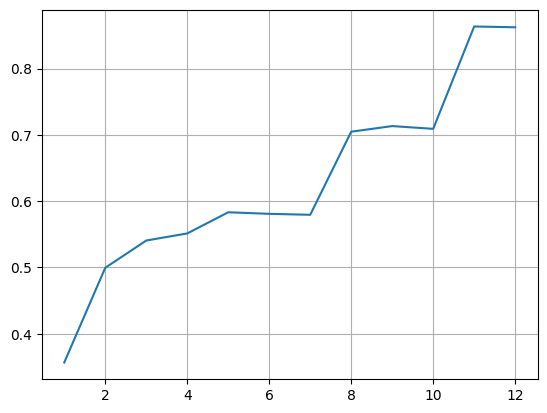

In [55]:
print("score_OptimisationOneHot :", score_OptimisationOneHot)

plt.figure()
plt.plot(iList, score_OptimisationOneHot)
plt.grid()
plt.show()